# Markov Processes in Music

In [1]:
import musx
from musx import markov, markov_analyze, Note, Seq, Score, MidiFile,\
    fit, interp, pick, between, intempo, keynum, rhythm, odds, choose, playfile
musx.setmidiplayer("fluidsynth -iq -g1 /Users/taube/Music/SoundFonts/MuseScore_General.sf2")
print(musx.version)

2.0.6


A *markov process* (markov chain) is a random process whose outcomes are affected by previous choices (<I>conditional probability</I>).
<P ALIGN=CENTER><IMG SRC="img/Markov3.jpg">

Internally we can think of this process as a table of conditional probabilities: each row defines the outcome probabilities of one (or more) past choices, and outcomes of the process are fed back into the process to become the past outcome that determines the next output.
    
<IMG SRC="img/Markov4.jpg">

* Line one says: The probablity of A given A is .5 and the probabilty of B given A is .5.
* Line two says: The probability of A given B is .2 and the probability of B given B is .8.

What is the probability of sequence ABA given A? 

<p>P<sub>ba</sub> * P<sub>ab</sub> = .5*.2 = .1</p>


<p>
A Markov process can be easily represented as a <I>transition table</I> that maps inputs to outputs according to probabilities.  The total proability of each transition (row) must equal 1.0, meaning that some outcome in a row must result from the past choice(s).
</p>

<IMG SRC="img/Markov5.jpg">

<p>A Markov process is generic, it can be applied to anything by mapping outcome probabilties to specific data. In music this data might be pitches, rhythms, harmony, etc.</p>

<IMG SRC="img/Markov6.jpg">

<p>
Because past choices influence subsequent choices the process can <I>mimic</I> many types of real-world behavior. 
</p>    


### The markov generator

```musx.markov(rules, stop=None, initial=[])```

A generator that produces its items according to a dictionary of (nth order) transition rules whose keys and values link past outcomes to a set of possible future outcomes:

<code>{(*past1*, ...): [[<em>next</em>, <em>prob</em>], [<em>next</em>, <em>prob</em>], ...], 
  (*past2*, ...): [[<em>next</em>,<em>prob</em>], [<em>next</em>, <em>prob</em>], ...],
  ...}
</code>

Each key is a tuple of one or more past outcomes and its value is a list of probability/outcome pairs that determine the next outcome.

In [3]:
# Basic example 
rules = {('a'): [['b', 1], ['c', 3]], 
         ('b'): [['a', 1]], 
         ('c'): [['a', 5], ['c', 1], ['b', 2.5]]}
data = [x for x in markov(rules, stop=20)]
print(data)

['c', 'a', 'b', 'a', 'c', 'a', 'c', 'a', 'c', 'c', 'a', 'b', 'a', 'b', 'a', 'c', 'a', 'c', 'c', 'a']


For convenience sake, in the case of first order Markov where rules only use one past event (see example above) the rule's key can be the item itself, rather than a tuple containing that item.  In addition, any future value that would otherwise be a list with a weight of 1 can be replaced by just the future value.  

This next example uses both these convenieces to make a more readable version of the rules.

In [4]:
rules = {'a': ['b', ['c', 3]], 
         'b': ['a'], 
         'c': [['a', 5], 'c', ['b', 2.5]]}
data = [x for x in markov(rules, stop=20)]
print(data)

['c', 'b', 'a', 'c', 'a', 'c', 'a', 'c', 'a', 'c', 'b', 'a', 'c', 'a', 'b', 'a', 'c', 'a', 'c', 'a']


In [5]:
# support

import matplotlib.pyplot as plt

def hist (items):
    d = dict.fromkeys(items)
    for i in d:
        d[i] = items.count(i)
    return d

def plothist(items):
    plt.hist(items, bins=len(dict.fromkeys(items)))

def envplot(env):
    x, y = env[::2], env[1::2]
    plt.plot(x, y)
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.show()

print('OK!')

OK!


### Markov orders and markov_analyze()

One of the most interesting uses of Markov is to model real-world phenomena by analyzing its outcome (data) to extract the probability of its next outcome given N previous outcomes. Given such an analysis one can then generate 'Markov chains' with characteristics statistically similar to the original data. How similar the results will depend on the number of previous outcomes N used to determine the next outcome.
The number N ois called the *markov order* of the process, and as the order increases, a markov process will come closer and closer to exactly mimicing the data it is derived from.

The next few examples demonstrate the effect of increasing the order of a markov process.  By increasing the Markov order the process produces a melody that comes closer and closer to the original.

In [6]:
# setup

melody = [60, 60, 62, 60, 65, 64, 60, 60, 62, 60, 67, 65,
          60, 60, 72, 69, 65, 64, 62, 70, 70, 69, 65, 67, 65]

def markovmelody(score, reps, rules, rate):
    pat = musx.markov(rules)
    for _ in range(reps):
      score.add(musx.Note(time=score.now, pitch=next(pat), duration=rate * 1.5))
      yield rate
        
def playmarkov(rules):
    seq=Seq()
    score=Score(out=seq)
    score.compose( markovmelody(score, 50, rules, .2) )
    f=MidiFile("markovmelody.mid", seq).write()
    playfile(f.pathname)
    return rules
    
print('OK!')

OK!


markov: {(): [[60, 8], [62, 3], [65, 5], [64, 2], [67, 2], [72, 1], [69, 2], [70, 2]]}


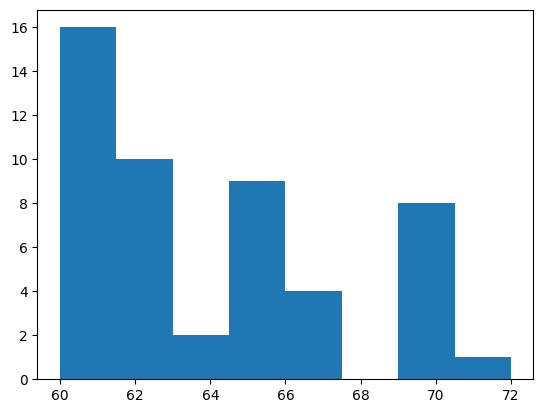

In [15]:
# Zeroth order Markov is equivalent to weighted random selection using the choose() generator.
rules = musx.markov_analyze(melody, order=0)
print("markov:", rules)
a,b = zip(*rules[()])
#print("choose:", list(a), list(b))
data = [x for x in musx.choose(list(a),list(b), 50)]
plothist(data)

def choosemelody(score, data, rate):
    for d in data:
      score.add(Note(time=score.now, pitch=d, duration=rate * 1.5))
      yield rate
seq=Seq()
score=Score(out=seq)
score.compose( choosemelody(score, data, .2) )
f=MidiFile("markovmelody.mid", seq).write()
playfile(f.pathname)

In [10]:
# 1st order Markov considers one past value

rules = musx.markov_analyze(melody, order=1)
playmarkov(rules)

{(60,): [[60, 3], [62, 2], [65, 1], [67, 1], [72, 1]],
 (62,): [[60, 2], [70, 1]],
 (65,): [[64, 2], [60, 2], [67, 1]],
 (64,): [[60, 1], [62, 1]],
 (67,): [[65, 2]],
 (72,): [[69, 1]],
 (69,): [[65, 2]],
 (70,): [[70, 1], [69, 1]]}

In [11]:
# 2nd order Markov considers two past values

rules = musx.markov_analyze(melody, order=2)
playmarkov(rules)

{(60, 60): [[62, 2], [72, 1]],
 (60, 62): [[60, 2]],
 (62, 60): [[65, 1], [67, 1]],
 (60, 65): [[64, 1]],
 (65, 64): [[60, 1], [62, 1]],
 (64, 60): [[60, 1]],
 (60, 67): [[65, 1]],
 (67, 65): [[60, 2]],
 (65, 60): [[60, 2]],
 (60, 72): [[69, 1]],
 (72, 69): [[65, 1]],
 (69, 65): [[64, 1], [67, 1]],
 (64, 62): [[70, 1]],
 (62, 70): [[70, 1]],
 (70, 70): [[69, 1]],
 (70, 69): [[65, 1]],
 (65, 67): [[65, 1]]}

In [12]:
# 3rd order Markov 

rules = musx.markov_analyze(melody, order=3)
playmarkov(rules)

{(60, 60, 62): [[60, 2]],
 (60, 62, 60): [[65, 1], [67, 1]],
 (62, 60, 65): [[64, 1]],
 (60, 65, 64): [[60, 1]],
 (65, 64, 60): [[60, 1]],
 (64, 60, 60): [[62, 1]],
 (62, 60, 67): [[65, 1]],
 (60, 67, 65): [[60, 1]],
 (67, 65, 60): [[60, 2]],
 (65, 60, 60): [[72, 1], [62, 1]],
 (60, 60, 72): [[69, 1]],
 (60, 72, 69): [[65, 1]],
 (72, 69, 65): [[64, 1]],
 (69, 65, 64): [[62, 1]],
 (65, 64, 62): [[70, 1]],
 (64, 62, 70): [[70, 1]],
 (62, 70, 70): [[69, 1]],
 (70, 70, 69): [[65, 1]],
 (70, 69, 65): [[67, 1]],
 (69, 65, 67): [[65, 1]],
 (65, 67, 65): [[60, 1]]}

In [13]:
# 4th order Markov 

rules = musx.markov_analyze(melody, order=4)
playmarkov(rules)

{(60, 60, 62, 60): [[65, 1], [67, 1]],
 (60, 62, 60, 65): [[64, 1]],
 (62, 60, 65, 64): [[60, 1]],
 (60, 65, 64, 60): [[60, 1]],
 (65, 64, 60, 60): [[62, 1]],
 (64, 60, 60, 62): [[60, 1]],
 (60, 62, 60, 67): [[65, 1]],
 (62, 60, 67, 65): [[60, 1]],
 (60, 67, 65, 60): [[60, 1]],
 (67, 65, 60, 60): [[72, 1], [62, 1]],
 (65, 60, 60, 72): [[69, 1]],
 (60, 60, 72, 69): [[65, 1]],
 (60, 72, 69, 65): [[64, 1]],
 (72, 69, 65, 64): [[62, 1]],
 (69, 65, 64, 62): [[70, 1]],
 (65, 64, 62, 70): [[70, 1]],
 (64, 62, 70, 70): [[69, 1]],
 (62, 70, 70, 69): [[65, 1]],
 (70, 70, 69, 65): [[67, 1]],
 (70, 69, 65, 67): [[65, 1]],
 (69, 65, 67, 65): [[60, 1]],
 (65, 67, 65, 60): [[60, 1]],
 (65, 60, 60, 62): [[60, 1]]}

In [14]:
# 5th order Markov

rules = musx.markov_analyze(melody, order=5)
playmarkov(rules)

{(60, 60, 62, 60, 65): [[64, 1]],
 (60, 62, 60, 65, 64): [[60, 1]],
 (62, 60, 65, 64, 60): [[60, 1]],
 (60, 65, 64, 60, 60): [[62, 1]],
 (65, 64, 60, 60, 62): [[60, 1]],
 (64, 60, 60, 62, 60): [[67, 1]],
 (60, 60, 62, 60, 67): [[65, 1]],
 (60, 62, 60, 67, 65): [[60, 1]],
 (62, 60, 67, 65, 60): [[60, 1]],
 (60, 67, 65, 60, 60): [[72, 1]],
 (67, 65, 60, 60, 72): [[69, 1]],
 (65, 60, 60, 72, 69): [[65, 1]],
 (60, 60, 72, 69, 65): [[64, 1]],
 (60, 72, 69, 65, 64): [[62, 1]],
 (72, 69, 65, 64, 62): [[70, 1]],
 (69, 65, 64, 62, 70): [[70, 1]],
 (65, 64, 62, 70, 70): [[69, 1]],
 (64, 62, 70, 70, 69): [[65, 1]],
 (62, 70, 70, 69, 65): [[67, 1]],
 (70, 70, 69, 65, 67): [[65, 1]],
 (70, 69, 65, 67, 65): [[60, 1]],
 (69, 65, 67, 65, 60): [[60, 1]],
 (65, 67, 65, 60, 60): [[62, 1]],
 (67, 65, 60, 60, 62): [[60, 1]],
 (65, 60, 60, 62, 60): [[65, 1]]}

## Markov Modeling

### Markov Chanting

In the crudest of terms, a Gregorian Chant is characterized by mostly stepwise motion within a range of modal degrees. From any given tone there is more likelihood that a chant will move a step up or down than leap to a tone further away. The larger the skip, the more unlikely it is to occur. In addition, certain tones, such as the
final and tenor, have more influence over the melody than other tones. For example, in the Dorian mode the tenor note A is occasionally decorated by the B-flat directly above it. This B-flat almost always returns back to the tenor tone. In an authentic mode, the final of the mode also acts as a kind of reflecting boundary
that redirects the melody in the opposite direction. 

We can mimic these stylistic tendencies using a first order Markov process:

In [16]:
chantrules = { 
    ('d4',): [['d4', .1],  ['e4', .35], ['f4', .25], ['g4', .1], ['a4', .15]],
    ('e4',): [['d4', .35], ['e4', .1], ['f4', .35], ['g4', .1], ['a4', 1]],
    ('f4',): [['d4', .2], ['e4', .2], ['f4', .1], ['g4', .2], ['a4', .12]],
    ('g4',): [['d4', .2], ['e4', .1], ['f4', .3], ['g4', .1], ['a4', .3], ['bf4', .2]],
    ('a4',): [['d4', .1], ['e4', .1], ['f4', .2], ['g4', .3], ['a4', .2], ['bf4', .3]],
    ('bf4',): [['a4', 1]]
}

def monk(score, reps, chant, rhy):
    pat = markov(chant)
    for _ in range(reps):
        k = keynum(next(pat))
        n = Note(time=score.now, pitch=k, duration=rhy)
        score.add(n)
        yield rhy
        
def playchant(rules):
    m=MidiFile.metatrack(ins={0: musx.midi.gm.ChoirAahs})
    t=Seq()
    s=Score(out=t)
    s.compose( monk(s, 50, chantrules, .35) )
    f=musx.MidiFile("chant.mid", [m, t]).write()
    musx.playfile(f.pathname)
    return rules

In [18]:
playchant(chantrules)

{('d4',): [['d4', 0.1], ['e4', 0.35], ['f4', 0.25], ['g4', 0.1], ['a4', 0.15]],
 ('e4',): [['d4', 0.35], ['e4', 0.1], ['f4', 0.35], ['g4', 0.1], ['a4', 1]],
 ('f4',): [['d4', 0.2], ['e4', 0.2], ['f4', 0.1], ['g4', 0.2], ['a4', 0.12]],
 ('g4',): [['d4', 0.2],
  ['e4', 0.1],
  ['f4', 0.3],
  ['g4', 0.1],
  ['a4', 0.3],
  ['bf4', 0.2]],
 ('a4',): [['d4', 0.1],
  ['e4', 0.1],
  ['f4', 0.2],
  ['g4', 0.3],
  ['a4', 0.2],
  ['bf4', 0.3]],
 ('bf4',): [['a4', 1]]}

In the next example we can add some rhythmic interest by possibly adjusting the duration if the note is in the tonic triad and always making sure the last note is the tonic.

In [19]:
def chant_dur(knum, dur):
    pc = knum % 12
    if pc == 2:
        return odds(.7, dur * 2, dur)
    elif pc == 9:
        return odds(.5, dur * 2, dur)
    elif pc == 5:
        return odds(.25, dur * 2, dur)
    return dur

def choir_monk(score, endtime, chant, dur, octave):
    pat = markov(chant)
    while True:
        k = keynum(next(pat))
        if score.elapsed > endtime and ((k % 12) == 2):
            yield -1
        d = chant_dur(k, dur)
        score.add(Note(time=score.now, pitch=k+octave, amplitude=.8, duration=dur))
        yield dur

In [21]:
t=Seq()
m=MidiFile.metatrack(ins={0: musx.midi.gm.ChoirAahs})
s=Score(out=t)
s.compose([choir_monk(s, 20, chantrules, .8, 6), 
           choir_monk(s, 20, chantrules, .8, 0) ,  
           choir_monk(s, 20, chantrules, .8, -6)])
f=MidiFile("chorus.mid", [m,t]).write()
playfile(f.pathname)

### Markov Harmony

A Markov process can be used to determine an interesting mix intervals that be stacked to create a chord.
This example uses the one table to create both the harmony <i>and</i> the melodic tones above it.


In [23]:
harmonyrules = {1: [[3, .4], [4, .4], [6, .1]],
                2: [[2, .2], [3, .4], [4, .4], [6, .1]],
                3: [[1, .2], [2, .6], [4, .4]],
                4: [[2, .2], [3, .4], [4, .4]],
                6: [[2, .4], [3, .2], [4, .2]]
}

def markov_harmonizer (score, length, rules, top, size, upward, rhy, dur):
    pat = markov(rules)
    for _ in range(length):
        i = next(pat)
        top = fit(top + odds(upward, i, -i), 50, 90)
        k = top
        for _ in range(size):
            m = Note(time=score.now, pitch=k, duration=dur)
            score.add(m)
            k -= next(pat)
        yield rhy

t=Seq()
m=MidiFile.metatrack(ins={0: musx.midi.gm.AcousticGrandPiano}) #musx.midi.gm.ChoirAahs
s=Score(out=t)
s.compose(markov_harmonizer(s, 25, harmonyrules, 67, 6, .7, 1.2, 1.2))
f=MidiFile("harmony.mid", [m,t]).write()
musx.playfile(f.pathname)

### Markov Rhythmic Patterns

Imagine generating a melody for a soloist in which the rhythms are determined by weighted random selection. Even if only a few simple rhythms are used, a moments reflection tells us that since the random process can place sixteenths and dotted eighths anywhere within a beat, the sequence of rhythmic values that result will only occasionally line up with the start of a metric pulse. If a tempo curve is also applied it becomes even harder to get a sense of the underlying pulse. In this example, rhythms selected by weighted random selection (markov 0th order) are used
in conjuction with a tempo curve.


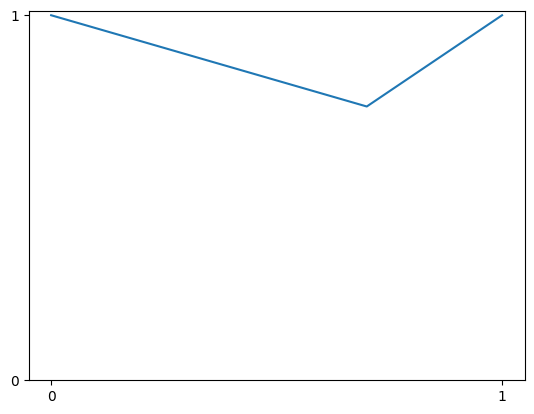

In [24]:
tcurve = [0, 1, .7, .75, 1, 1]
envplot(tcurve)

In [25]:

def ranrhythm(s, leng, rhys, lo, hi):
    tcurve = [0, 1, .7, .75, 1, 1]
    for i in range(leng):
        k = between(lo, hi)
        r = next(rhys)
        d = intempo(r, 120) * interp(i / leng, tcurve)
        m = Note(time=s.now, pitch=k, duration=d)
        s.add(m)
        yield d

rhythms = choose([1, .75, .5, .25])
        
t=Seq()
m=MidiFile.metatrack(ins={0: musx.midi.gm.Marimba})
s=Score(out=t)
s.compose(ranrhythm(s, 75, rhythms, 40, 80))
f=MidiFile("rhythm.mid", [m,t]).write()
playfile(f.pathname)

In the next version a first order markov process produces random variations that support the perception of an underlying pulse, even in the case of a tempo curve warping the timing.

|    	| q 	| e. 	| e   	| s     |
|----	|---	|---	|-----	|-----	|
| **q**: 	| .5 	| .75 	| 2   	| 2   	|
| **e.**: 	| 0 	| 0 	| 0   	| 1   	|
| **e**: 	| 2 	| 1 	| 2 	| 0   	|
| **s**: 	| 1 	| 0 	| 2 	| 1   	|

In [27]:
rules = {
    1: [[1, .5], [.75, .75], [.5, 2]],
    .75: [.25],
    .5: [[1, 2], .75, [.5, 2]],
    .25: [1, [.5, 2], .25]
}

rhythms = markov(rules)

t=Seq()
m=MidiFile.metatrack(ins={0: musx.midi.gm.Marimba})
s=Score(out=t)
s.compose(ranrhythm(s, 75, rhythms, 40, 80))
f=MidiFile("rhythm.mid", [m,t]).write()
playfile(f.pathname)

### Markov Texture



In [28]:
bwmotion = {
    0:  [[0, .5],  [2, 2],   [4, 1.5], [5, 1],   [7, .5],   [9, .5],  [11, .5],  [1, .2], [3, .1], [6, .1], [8, .1],  [10, .1]],
    1:  [[1, .5],  [3, 2],   [6, 1.5], [8, 1],   [10, 1],   [0, .2],  [2, .2],   [4, .1], [5, .1], [7, .1], [9, .1],  [11, .1]],
    2:  [[0, 2],   [2, .5],  [4, 2],   [5, 1.5], [7, 1],    [9, .5],  [1, .2],   [3, .2], [6, .1], [8, .1], [10, .1], [11, .1]],
    3:  [[1, 2],   [3, .5],  [6, 1.5], [8, 1],   [10, .5],  [0, .1],  [2, .2],   [4, .2], [5, .1], [7, .1], [9, .1],  [11, .1]],
    4:  [[0, 1.5], [2, 2],   [4, .5],  [5, 2],   [7, 1.5],  [9, 1],   [11, .5],  [1, .1], [3, .2], [6, .2], [8, .1],  [10, .1]],
    5:  [[0, 1],   [2, 1.5], [4, 2],   [5, .5],  [7, 2],    [9, 1.5], [11, 1],   [1, .1], [3, .2], [6, .2], [8, .1],  [10, .1]],
    6:  [[1, 1.5], [3, 2],   [6, .5],  [8, 2],   [10, 1.5], [0, .1],  [2, .1],   [4, .1], [5, .2], [7, .2], [9, .1],  [11, .1]],
    7:  [[0, .5],  [2, 1],   [4, 1.5], [5, 2],   [7, .5],   [9, 2],   [11, 1.5], [1, .1], [3, .1], [6, .2], [8, .2],  [10, .1]],
    8:  [[1, 1],   [3, 1.5], [6, 2],   [8, .5],  [10, 2],   [0, .1],  [2, .1],   [4, .1], [5, .1], [7, .2], [9, .2],  [11, .1]],
    9:  [[0, .5],  [2, .4],  [4, 1],   [5, 1.5], [7, 2],    [9, .5],  [11, 2],   [1, .1], [3, .1], [6, .1], [8, .2],  [10, .2]],
    10: [[1, .5],  [3, 1],   [6, 1.5], [8, 2],   [10, .5],  [0, .1],  [2, .1],   [4, .1], [5, .1], [7, .1], [9, .2],  [11, .2]],
    11: [[0, .5],  [2, .5],  [4, .5],  [5, 1],   [7, 1.5],  [9, 2],   [11, .5],  [1, .1], [3, .1], [6, .1], [8, .1],  [10, .2]]
}

bwoctaves = {
    'c3': [['c3', 2],   ['c4', 1],  ['c5', .5], ['c6', .25]],
    'c4': [['c3', 1],   ['c4', 2],  ['c5', 1],  ['c6', .5]],
    'c5': [['c3', .5],  ['c4', 1],  ['c5', 2],  ['c6', 1]],
    'c6': [['c3', .25], ['c4', .5], ['c5', 1],  ['c6', 2]]
}

def bwkeys(score, length, octlist, intlist, rate, chan):
    ints = markov(intlist)
    octs = markov(octlist)
    reps = 0
    octv = 0
    for _ in range(length):
        if reps == 0:
            reps = pick(4, 8, 12, 16)
            octv = keynum(next(octs))
        intr = next(ints)
        n = Note(time=score.now, duration=rate * 1, pitch=octv + intr, instrument=chan)
        score.add(n)
        reps = reps - 1
        yield rate

Listen to one voice:

In [ ]:
t=Seq()
m=MidiFile.metatrack(ins={0: musx.midi.gm.Marimba})
s=Score(out=t)
s.compose(bwkeys(s, 120, bwoctaves, bwmotion, .125, 0))
f=MidiFile("texture.mid", [m,t]).write()
playfile(f.pathname)

Listen to two voices:

In [30]:
t=Seq()
m=MidiFile.metatrack(ins={0: musx.midi.gm.Marimba, 1: musx.midi.gm.Marimba})
s=Score(out=t)
s.compose([[0, bwkeys(s, 120, bwoctaves, bwmotion, .125, 0)],
          [2, bwkeys(s, 120, bwoctaves, bwmotion, .125, 1)]])
f=MidiFile("texture.mid", [m,t]).write()
playfile(f.pathname)